# This notebook will process text from the posts dataset

Run LDA model

TFIDF vectorize for input to clustering model

Run KMeans Clustering model

- part of speech tag
- lowercase (but i think i should lower first then generate n-grams, this is reddit data, its the wild west of text input
- lemmatize

# stuff accomplished

- ✅ text cleaning
    - decided to leave in contractions as words, did not split them
    - potential extra step to processing would be splitting contractions into full words, use this:
        - https://github.com/slaps-lab/bibliotheca/blob/master/text/expand_contractions_with_spacy.ipynb
- ✅ LDA topic model (corpus input is a list of list of tokens, words and ngrams)
- ✅ TFIDF vectorizer (corpus input is a list of strings, each document is a string, no ngrams input into TFIDF)

### next time
- plots and other visuals
    - plot x-axis formatting for date of posts, want 7-day interval
- clustering model
- apply those things to the comments dataset (set it up to run overnight)
- follow the roadmap in this link with all the plots and everything, would make a really great capstone
    - https://www.kaggle.com/dfoly1/k-means-clustering-from-scratch

## Roadmap for data exploration and processing

- text processing stuff for nltk
    - actual preprocessing steps (use the functions from the NLP lecture and the NLP case study)
        - remove punctuation, newlines, links, any other special characters, replace numbers with #num, lowercase, strip, split, and join **may need to move the lowercase part depending on if stock symbols or proper nouns seem important later on, but reddidors yell a lot so maybe this is the best place to do it**
        - lemmatize/stem
        - n-grams
        - remove stopwords
        - count vectorize (for LDA topic model)
        - tfidf (for clustering model)
        - now ready to model
    - get some topics from the posts
    - also look into SpaCy for maybe a different analysis/point of view


- clustering model


- sentiment analysis model?

In [1]:
import nltk
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mat
plt.style.use('ggplot')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

import re
from collections import Counter
import emoji
from wordcloud import WordCloud

import time
from datetime import datetime as dt

In [2]:
main_posts = pd.read_csv('data/main_posts.csv')
main_posts.head()

,author,title,selftext,created_utc,num_comments,subreddit_subscribers,upvote_ratio
0,readyrummy1,Ruled by the Theta Gods,5:30 AM\n\nWoke up five minutes ago. Made som...,1607957430,6,1697978,1.0
1,officespace2020,Motivation Monday,"# Intro\n\nLet me get soft with ya, it can get...",1607957260,9,1697974,1.0
2,BigSlimetime73,Toy Yoda (but the car company),"Hello fellow retards,\n\nThis weekend I came a...",1607957127,4,1697963,1.0
3,shroomsAndWrstershir,"I've never been so happy to lose $300,000 in m...","After Saturday's SPCE failed launch, I though ...",1607957052,85,1697960,1.0
4,alphabluepiller,Nasdaq-100 changes,"NEW YORK, Dec. 11, 2020 (GLOBE NEWSWIRE) -- Na...",1607955881,7,1697898,1.0


In [3]:
main_posts.shape

(96482, 7)

In [4]:
corpus = []
for i in range(len(main_posts)):
    corpus.append([main_posts.selftext[i]])

In [5]:
main_posts.tail()

,author,title,selftext,created_utc,num_comments,subreddit_subscribers,upvote_ratio
96477,Dirtball26,WHY THE FUCK WONT ROBINHOOD LET ME OPTIONS TRADE.,Haven’t used since I got my free stock last ye...,1609094822,6,1746192,1.0
96478,Salahforisis,You fucking knuckleheads got my mom to reinves...,I don't know how the fuck you guys became so p...,1609094763,337,1746190,1.0
96479,Junkbot,GME 🚀🚀🚀🚀🚀🚀 = gold?,Saw the trends and trying a back test to see i...,1609093826,4,1746160,1.0
96480,ZookeepergameSoggy49,Was it a dream??!😴 😴 GME opens on Monday up 100%,Large GameStop Investor Ryan Cohen Buys More S...,1609093189,18,1746143,1.0
96481,johnfhoustontx,Trading Plan 2021 - Need your constructive input,\n\n# Trading Plan 2021\n\n# Daily Routine (...,1609093183,14,1746143,1.0


In [6]:
# datetime processing the created_utc column
date = []
datetime = []
for i in range(len(main_posts)):
    datetime.append(pd.to_datetime(dt.fromtimestamp(main_posts.created_utc[i])))
    date.append(pd.to_datetime(dt.fromtimestamp(main_posts.created_utc[i])).strftime('%Y-%m-%d'))

In [126]:
main_posts['DateTime'] = datetime
main_posts['Date'] = date

In [127]:
main_posts.head()

,author,title,selftext,created_utc,num_comments,subreddit_subscribers,upvote_ratio,DateTime,Date
0,readyrummy1,Ruled by the Theta Gods,5:30 AM\n\nWoke up five minutes ago. Made som...,1607957430,6,1697978,1.0,2020-12-14 07:50:30,2020-12-14
1,officespace2020,Motivation Monday,"# Intro\n\nLet me get soft with ya, it can get...",1607957260,9,1697974,1.0,2020-12-14 07:47:40,2020-12-14
2,BigSlimetime73,Toy Yoda (but the car company),"Hello fellow retards,\n\nThis weekend I came a...",1607957127,4,1697963,1.0,2020-12-14 07:45:27,2020-12-14
3,shroomsAndWrstershir,"I've never been so happy to lose $300,000 in m...","After Saturday's SPCE failed launch, I though ...",1607957052,85,1697960,1.0,2020-12-14 07:44:12,2020-12-14
4,alphabluepiller,Nasdaq-100 changes,"NEW YORK, Dec. 11, 2020 (GLOBE NEWSWIRE) -- Na...",1607955881,7,1697898,1.0,2020-12-14 07:24:41,2020-12-14


In [139]:
top_10_posters = main_posts.groupby('author')['title'].count().sort_values(ascending=False)[2:12]
top_10_posters

author
0toHeroInvesting    54
WSBVoteBot          40
ineedhelpdude11     38
JasonColin          35
Tereek7504          31
phase-one1          26
vitocorlene         24
deltalake           24
-paraZite           23
thisshitisfiya      21
Name: title, dtype: int64

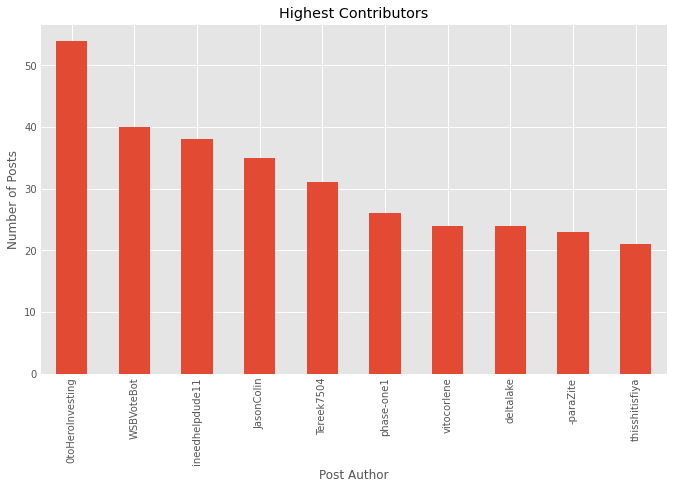

In [169]:
fig,ax = plt.subplots(figsize=(10,6))
top_10_posters.plot(kind='bar')
plt.xlabel('Post Author')
plt.ylabel('Number of Posts')
plt.title('Highest Contributors');

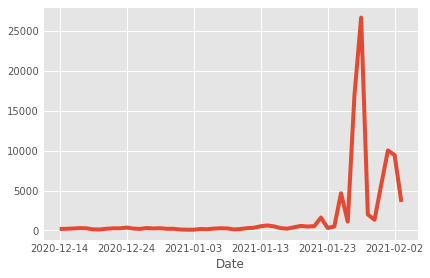

In [170]:
fig, ax = plt.subplots()

indices = main_posts['Date'] >= ('2020-12-14')
main_posts.loc[indices].groupby('Date')['selftext'].count().plot()


# base = main_posts['Date'][0]
# plt.xticks(np.arange(base + dt.timedelta(days=1)))

# ax.xaxis.set_major_locator(mdates.DayLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# ax.xaxis.set_major_formatter(mat.ticker.FormatStrFormatter('%d'))

# locator = mdates.DayLocator()
# fmt = mdates.DateFormatter('%d')
# X = plt.gca().xaxis
# X.set_major_locator(locator)
# X.set_major_formatter(fmt)

In [162]:
wordcloud = WordCloud(
    collocations = False,
    width = 1600, height = 800,
    background_color = 'white',
    stopwords = stop_words,
    max_words = 150).generate(' '.join(tfidf_corpus))

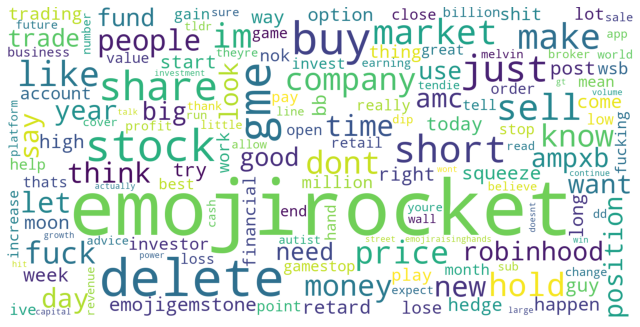

In [171]:
plt.figure(figsize=(10,6))
fig=plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off');

### test out some emoji handling

In [16]:
# these are all the currently used emojis in the unicode emoji library

emoji.UNICODE_EMOJI_ENGLISH

{'🥇': ':1st_place_medal:',
 '🥈': ':2nd_place_medal:',
 '🥉': ':3rd_place_medal:',
 '🆎': ':AB_button_(blood_type):',
 '🏧': ':ATM_sign:',
 '🅰': ':A_button_(blood_type):',
 '🇦🇫': ':Afghanistan:',
 '🇦🇱': ':Albania:',
 '🇩🇿': ':Algeria:',
 '🇦🇸': ':American_Samoa:',
 '🇦🇩': ':Andorra:',
 '🇦🇴': ':Angola:',
 '🇦🇮': ':Anguilla:',
 '🇦🇶': ':Antarctica:',
 '🇦🇬': ':Antigua_&_Barbuda:',
 '♒': ':Aquarius:',
 '🇦🇷': ':Argentina:',
 '♈': ':Aries:',
 '🇦🇲': ':Armenia:',
 '🇦🇼': ':Aruba:',
 '🇦🇨': ':Ascension_Island:',
 '🇦🇺': ':Australia:',
 '🇦🇹': ':Austria:',
 '🇦🇿': ':Azerbaijan:',
 '🔙': ':BACK_arrow:',
 '🅱': ':B_button_(blood_type):',
 '🇧🇸': ':Bahamas:',
 '🇧🇭': ':Bahrain:',
 '🇧🇩': ':Bangladesh:',
 '🇧🇧': ':Barbados:',
 '🇧🇾': ':Belarus:',
 '🇧🇪': ':Belgium:',
 '🇧🇿': ':Belize:',
 '🇧🇯': ':Benin:',
 '🇧🇲': ':Bermuda:',
 '🇧🇹': ':Bhutan:',
 '🇧🇴': ':Bolivia:',
 '🇧🇦': ':Bosnia_&_Herzegovina:',
 '🇧🇼': ':Botswana:',
 '🇧🇻': ':Bouvet_Island:',
 '🇧🇷': ':Brazil:',
 '🇮🇴': ':British_Indian_Ocean_Territory:',
 '🇻🇬': ':British_Vir

In [7]:
# test strings for processing with emojis

test1 = main_posts.title[96479]
test2 = main_posts.title[96480]
print(test1)
print(test2)

GME 🚀🚀🚀🚀🚀🚀 = gold?
Was it a dream??!😴 😴 GME opens on Monday up 100%


In [8]:
test3 = test1 + "\\n this is g'onna be *&% good https://yourmom"
test3

"GME 🚀🚀🚀🚀🚀🚀 = gold?\\n this is g'onna be *&% good https://yourmom"

In [20]:
# emoji extraction with regex

re.findall(r'[^\w\s\n?=,]', test1)

['🚀', '🚀', '🚀', '🚀', '🚀', '🚀']

In [23]:
# this is the output from the emoji dictionary, not totally digging the format with the colons bookending the word

emoji.UNICODE_EMOJI_ENGLISH['🚀']

':rocket:'

In [18]:
# function translates emojis from

def translate_emoji(sentence):
    translated = []
    for word in sentence.split():
        if word in emoji.UNICODE_EMOJI_ENGLISH:
            translated.append(emoji.UNICODE_EMOJI_ENGLISH[word])
        else:
            translated.append(word)
    return translated

In [24]:
translate_emoji(test1)

['GME', '🚀🚀🚀🚀🚀🚀', '=', 'gold?']

In [26]:
# the toked function modifies the translate emoji output so that the word 'emoji' is included at the front, 
# and the rest of the toked function has parts for removing special characters

translate_emoji(toked(test1))

['GME',
 'emojirocket',
 'emojirocket',
 'emojirocket',
 'emojirocket',
 'emojirocket',
 'emojirocket',
 'gold']

In [27]:
translate_emoji(toked(test2))

['Was',
 'it',
 'a',
 'dream',
 'emojisleepingface',
 'emojisleepingface',
 'GME',
 'opens',
 'on',
 'Monday',
 'up']

# main functions for processing the text of each post

In [28]:
# several of the processing functions were copied from the NLP lecture


# the toked function:
# removes newline characters
# removes apostrophes, easier to just remove apostrophes and leave naked contractions rather than expand them
    # there's only like what a handful of common contractions, they can be words for this as far as i'm concerned
# removes links that have the format 'https://etc'
# removes special characters
# replaces any number in the string with num
# returns this split stripped and joined back together to remove multiple blanks
# runs this through the nltk RegexTokenizer modified to handle emojis, which splits individual emojis
    # so that three rocketships is 3 occurrences of one rocketship, etc. instead of its own separate character
# finally translates emojis from their emoji symbol to a word representation of it so that ngrams captures these
tokenizer = RegexpTokenizer(r'\w+|[^\w\s]')
link_regex = re.compile(r'(https://)[a-z./0-9?=&;-]*')
numbers = re.compile(r'([0-9],?)+')
apostrophe = re.compile(r"\'|’") # heads up for both versions of the apostrophe!! dammit ' and ’
newline = re.compile(r'(\\n)')
specials = re.compile(r'[-+~`:;@=\'’"”#“$|,%/&^•·)(\]\[\*\\?!\._]')
def toked(doc):
    modified = newline.sub(' ', doc)
    modified = apostrophe.sub('', modified)
    modified = link_regex.sub('', modified)
    modified = specials.sub('', modified)
    modified = numbers.sub('', modified)
    modified = ' '.join(modified.split()).strip()
    modified = tokenizer.tokenize(modified)
    
    translated = []
    for word in modified:
        if word in emoji.UNICODE_EMOJI_ENGLISH:
            translated.append('emoji_' + emoji.UNICODE_EMOJI_ENGLISH[word])
        else:
            translated.append(word)
    
    translated = ' '.join(translated)
    modified = ' '.join(specials.sub('', translated).split()).strip()
            
    return modified


# lemmatize
def lemmatize(doc):
    # get the words in the document
    words = re.findall("\w+|[^\w\s]", doc)
    # get the parts of speech
    pos_tokens = nltk.pos_tag(words)
    
    # process_word(*token) uses star args to supply both word and part of speech to process_word
    # for token in pos_tokens - we want to do this for every token in the document
    
    return ' '.join([process_word(*token) for token in pos_tokens])


def process_word(word, pos):
    lemmatizer = WordNetLemmatizer()
    pos_dict = {'J':'a', 'V':'v', 'N':'n', 'R': 'r'}
    if pos[0] in pos_dict:
        return lemmatizer.lemmatize(word.lower(), pos_dict[pos[0]])
    else:
        return lemmatizer.lemmatize(word.lower())
    

# extract n-grams
def get_ngrams(doc):
    # build vectorizer and analyzer
    vectorizer = CountVectorizer(ngram_range=(2,3), preprocessor=None, tokenizer=None).build_analyzer()
    # return the n-grams of size 2 and 3 without stop words in this case
    return vectorizer(doc, stop_words=stopwords.words('english'))


# remove stopwords
my_additional_stop_words =  ('im', '', 'ud', 'pc', 'ampxb', 'unum', 'numc', 'unuma', 'unumd', 'num', 'numm', 'numk', 'xnumb', 'amp', 'im', 'ampxnumb', 'numlt', 'numnd', "ampxnumb")
stop_words = text.ENGLISH_STOP_WORDS #.union(my_additional_stop_words)
real_words = ''
def remove_stop_words(words):
#     words_split = words.split()
#     for word in words.split
    return [word for word in words.split() if word not in stop_words]

## function for doing all the text processing at once

In [56]:
# full processing workflow, removing stop words before generating ngrams
def processing(doc):
    tokens = toked(str(doc)) # returns a string
    words = lemmatize(tokens) # returns a string
    words = remove_stop_words(words) # returns a list
    ngrams = get_ngrams(' '.join(words)) # returns a list
    return words + ngrams # returns a list of lists of words and ngrams

def tfidf_processing(doc):
    tokens = toked(str(doc)) # returns a string
    words = lemmatize(tokens) # returns a string
    words = remove_stop_words(words) # returns a list
    return ' '.join(words) # returns a list of strings, no ngrams

# full processing workflow, ngrams generated before removing stop words
# def full_processing(doc):
#     tokens = toked(str(doc)) # returns a string
#     ngrams = get_ngrams(tokens) # returns a list
#     words = lemmatize(tokens) # returns a string
#     words = remove_stop_words(words) # returns a list
    
#     return words + ngrams

### testing out several of the sub functions...

In [41]:
test3

"GME 🚀🚀🚀🚀🚀🚀 = gold?\\n this is g'onna be *&% good https://yourmom"

In [42]:
toked(test3)

'GME emojirocket emojirocket emojirocket emojirocket emojirocket emojirocket gold this is gonna be good'

In [43]:
get_ngrams(toked(test3))

['gme emojirocket',
 'emojirocket emojirocket',
 'emojirocket emojirocket',
 'emojirocket emojirocket',
 'emojirocket emojirocket',
 'emojirocket emojirocket',
 'emojirocket gold',
 'gold gonna',
 'gonna good',
 'gme emojirocket emojirocket',
 'emojirocket emojirocket emojirocket',
 'emojirocket emojirocket emojirocket',
 'emojirocket emojirocket emojirocket',
 'emojirocket emojirocket emojirocket',
 'emojirocket emojirocket gold',
 'emojirocket gold gonna',
 'gold gonna good']

In [44]:
full_processing(test3, 'string')

['gme',
 'emojirocket',
 'emojirocket',
 'emojirocket',
 'emojirocket',
 'emojirocket',
 'emojirocket',
 'gold',
 'gonna',
 'good',
 'gme emojirocket',
 'emojirocket emojirocket',
 'emojirocket emojirocket',
 'emojirocket emojirocket',
 'emojirocket emojirocket',
 'emojirocket emojirocket',
 'emojirocket gold',
 'gold gonna',
 'gonna good',
 'gme emojirocket emojirocket',
 'emojirocket emojirocket emojirocket',
 'emojirocket emojirocket emojirocket',
 'emojirocket emojirocket emojirocket',
 'emojirocket emojirocket emojirocket',
 'emojirocket emojirocket gold',
 'emojirocket gold gonna',
 'gold gonna good']

In [45]:
full_processing(test3, 'list')

'gme emojirocket emojirocket emojirocket emojirocket emojirocket emojirocket gold gonna good'

## First Pass at processing and LDA modeling the posts

prediction is it will take about 40 minutes to run the full processing on the full corpus of 96000 posts

update: it took about 14 minutes

In [178]:
%%time

# this cell and the above cell populating the processed list of posts were the first run of the full data
# processing, which produced n-grams and then joined them together with the other words from the lemmatizer
# back into a string before passing that to CountVectorizer.
# the problem with this approach was all the n-gram data was lost when joining that back together before passing
# into CountVectorizer. And then CountVectorizer was also generating its own n-grams, so there was a lot of data 
# confusion in the first pass with this approach. However, the outputs from this first LDA model are entertaining.


# the output from full_processing is a string of tokens joined back together, which loses a lot of the value of 
# the previous preprocessing steps, particularly the ngrams
processed = []
for doc in corpus:
    processed.append(full_processing(doc))


my_additional_stop_words =  ('unum', 'numc', 'unuma', 'unumd', 'num', 'numk', 'xnumb', 'amp', 'im')
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

vectorizer = CountVectorizer(stop_words=stop_words, max_df=0.85, min_df=2, max_features=2500)
X = vectorizer.fit_transform(processed)
features = vectorizer.get_feature_names()

lda = LatentDirichletAllocation(n_components=10, random_state=42, learning_method='online', n_jobs=-1)
lda.fit(X)
print(lda.components_.shape)
top_components = lda.components_.argsort()[:,-1:-11:-1]

# top_components.shape
for i, v in enumerate(top_components):
    print(i, [features[i] for i in v])

(10, 2500)
0 ['short', 'shares', 'sell', 'gme', 'share', 'squeeze', 'price', 'shorts', 'melvin', 'position']
1 ['hold', 'gme', 'fuck', 'fucking', 'buy', 'let', 'shit', 'moon', 'dont', 'going']
2 ['amc', 'robinhood', 'gme', 'buy', 'delete', 'nok', 'account', 'app', 'rh', 'gamestop']
3 ['company', 'year', 'market', 'million', 'stock', 'price', 'growth', 'business', 'companies', 'revenue']
4 ['emojirocket', 'emojigemstone', 'emojiraisinghands', 'gme', 'emojigorilla', 'emojifullmoon', 'moon', 'emojiopenhands', 'sndl', 'emojiraisedhand']
5 ['wsb', 'best', 'day', 'week', 'daily', 'meme', 'dd', 'yolo', 'restrictsr', 'weekly']
6 ['stock', 'market', 'buy', 'hedge', 'funds', 'buying', 'stocks', 'today', 'like', 'trading']
7 ['bb', 'gt', 'pltr', 'data', 'stock', 'com', 'cnbc', 'link', 'click', 'chart']
8 ['wall', 'street', 'market', 'news', 'tesla', 'big', 'power', 'world', 'class', 'group']
9 ['people', 'money', 'like', 'make', 'know', 'want', 'think', 'time', 'good', 'really']
CPU times: user 2

## Second pass at processing and LDA modeling, much better approach and data handling

###  some extra stuff to address:

stop words can only be applied inside of the count vectorizer IF "analyzer == 'word'", but since i'm trying a new thing with the analyzer=lambda function, i need to remove the stopwords in the full_processing function


~need to keep tweaking the special characters and stop words, which are somehow leaking into the processed corpus still.~

remove links, specials, apostrophes, before ngrams, then do stop words removal.

    ok, i've got ngrams generated in full_processing function
    i've got stop words removed in full_processing function
    i've got all specials addressed in full processing function

In [57]:
%%time
t0 = time.time()

# running this again with a different output from full processing, a list of tokens rather than
# the tokens rejoined into a string
processed = []
for doc in corpus:
    processed.append(processing(doc))

    
t1 = time.time()
print('time elapsed for corpus processing: ' + str(time.strftime('%M:%S', time.localtime(t1 - t0))) + '\n')


vectorizer = CountVectorizer(stop_words=None, 
                             max_df=0.85, 
                             min_df=2, 
                             max_features=2500,
                             tokenizer=None,
                             lowercase=False, 
                             preprocessor=None,
                             analyzer=lambda x: x)
#                              ngram_range=(1,3))

X = vectorizer.fit_transform(processed)
features = vectorizer.get_feature_names()


t2 = time.time()
print('time elapsed for count vectorizer: ' + str(time.strftime('%M:%S', time.localtime(t2 - t1))) + '\n')


lda = LatentDirichletAllocation(n_components=10, random_state=42, learning_method='online', n_jobs=-1)
lda.fit(X)
print(lda.components_.shape)
top_components = lda.components_.argsort()[:,-1:-11:-1]

# top_components.shape
for i, v in enumerate(top_components):
    print(i, [features[i] for i in v])
    
    
t3 = time.time()
print('\n' + 'time elapsed for LDA model: ' + str(time.strftime('%M:%S', time.localtime(t3 - t2))) + '\n')

time elapsed for corpus processing: 03:28
time elapsed for count vectorizer: 00:05
(10, 2500)
0 ['buy', 'sell', 'share', 'price', 'option', 'hold', 'sell sell sell', 'buy share', 'close', 'silver']
1 ['market', 'stock', 'price', 'share', 'company', 'short', 'high', 'million', 'm', 'day']
2 ['make', 'people', 'money', 'u', 'need', 'market', 'fuck', 'like', 'know', 'wall']
3 ['amc', 'bb', 'nok', 'gme', 'let', 'moon', 'buy', 'gme amc', 'nokia', 'amc amc']
4 ['emojirocket', 'emojirocket emojirocket', 'emojirocket emojirocket emojirocket', 'emojigemstone', 'emojiraisinghands', 'emojigemstone emojigemstone', 'moon emojirocket', 'emojigemstone emojigemstone emojigemstone', 'gme', 'moon emojirocket emojirocket']
5 ['gme', 'short', 'hold', 'buy', 'fuck', 'sell', 'squeeze', 'dont', 'let', 'share']
6 ['im', 'stock', 'just', 'like', 'know', 'think', 'dont', 'good', 'make', 'look']
7 ['robinhood', 'ampxb', 'account', 'stock', 'trading', 'trade', 'buy', 'use', 'rh', 'app']
8 ['company', 'pump', 'yea

In [59]:
print(list(emoji.UNICODE_EMOJI_ENGLISH.keys())[list(emoji.UNICODE_EMOJI_ENGLISH.values()).index(':open_hands:')] + ' open_hands')
print(list(emoji.UNICODE_EMOJI_ENGLISH.keys())[list(emoji.UNICODE_EMOJI_ENGLISH.values()).index(':raising_hands:')] + ' raising_hands')
print(list(emoji.UNICODE_EMOJI_ENGLISH.keys())[list(emoji.UNICODE_EMOJI_ENGLISH.values()).index(':gem_stone:')] + ' gem_stone')
print(list(emoji.UNICODE_EMOJI_ENGLISH.keys())[list(emoji.UNICODE_EMOJI_ENGLISH.values()).index(':rocket:')] + ' rocket')
print(list(emoji.UNICODE_EMOJI_ENGLISH.keys())[list(emoji.UNICODE_EMOJI_ENGLISH.values()).index(':gorilla:')] + ' gorilla')

👐 open_hands
🙌 raising_hands
💎 gem_stone
🚀 rocket
🦍 gorilla


In [60]:
bag = []
for doc in processed:
    for word in doc:
        bag.append(word)

In [61]:
Counter(bag).most_common()

[('emojirocket', 99482),
 ('emojirocket emojirocket', 85728),
 ('emojirocket emojirocket emojirocket', 75559),
 ('delete', 35623),
 ('gme', 25983),
 ('buy', 25646),
 ('stock', 24987),
 ('share', 20665),
 ('short', 18434),
 ('just', 17796),
 ('sell', 16723),
 ('make', 15988),
 ('market', 15774),
 ('like', 15637),
 ('im', 15049),
 ('hold', 13444),
 ('price', 13136),
 ('dont', 12962),
 ('company', 12917),
 ('know', 12328),
 ('u', 12238),
 ('fuck', 11552),
 ('money', 11265),
 ('time', 10840),
 ('people', 10736),
 ('let', 10536),
 ('think', 9952),
 ('day', 9151),
 ('want', 9064),
 ('year', 8995),
 ('amc', 8946),
 ('say', 8613),
 ('ampxb', 8496),
 ('robinhood', 8054),
 ('position', 7993),
 ('new', 7893),
 ('good', 7726),
 ('look', 7708),
 ('big', 7368),
 ('trade', 7136),
 ('use', 7094),
 ('fund', 7020),
 ('need', 6797),
 ('emojigemstone', 6754),
 ('post', 6691),
 ('retard', 6569),
 ('try', 6453),
 ('squeeze', 6408),
 ('come', 6288),
 ('right', 6263),
 ('week', 6179),
 ('today', 6084),
 ('hig

In [62]:
tfidf_corpus = []
for doc in corpus:
    tfidf_corpus.append(tfidf_processing(doc))

In [65]:
tf_idf_vectorizer = TfidfVectorizer(lowercase=False, analyzer= lambda x: x, ngram_range=(1,3) )
tf_idf = tf_idf_vectorizer.fit_transform(processed)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

In [67]:
tf_idf_vectorizer.get_feature_names()

['aa',
 'aa able',
 'aa able advantage',
 'aa alcoa',
 'aa alcoa aluminum',
 'aa american',
 'aa american airline',
 'aa ampxb',
 'aa ampxb crisprtherapeuticscommentskhqpycrspatathcrisprtherapeuticscommentskhqpycrspatath',
 'aa apdn',
 'aa apdn rmo',
 'aa cashapp',
 'aa cashapp straight',
 'aa cg',
 'aa cg fuse',
 'aa cunt',
 'aa cunt make',
 'aa emojirocket',
 'aa emojirocket emojirocket',
 'aa gt',
 'aa gt returnaa',
 'aa guy',
 'aa guy access',
 'aa hyundaikia',
 'aa hyundaikia partner',
 'aa july',
 'aa july amp',
 'aa let',
 'aa let chamath',
 'aa mall',
 'aa mall matter',
 'aa mind',
 'aa mind blow',
 'aa moon',
 'aa notice',
 'aa notice clearly',
 'aa pre',
 'aa pre mkt',
 'aa profit',
 'aa qrr',
 'aa qrr notice',
 'aa retard',
 'aa retard frick',
 'aa return',
 'aa return independent',
 'aa short',
 'aa short squeeze',
 'aa speak',
 'aa speak fukk',
 'aa trifecta',
 'aa trifecta meme',
 'aa wait',
 'aa wait patiently',
 'aa way',
 'aa way short',
 'aaa',
 'aaa company',
 'aaa c

### KMeans clustering

In [ ]:
%%time

n_clusters = 2
sklearn_pca = PCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters=n_clusters, max_iter = 600, algorithm = 'auto')
%time fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

In [ ]:
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction ,s=50, cmap='viridis')
centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=300, alpha=0.6);